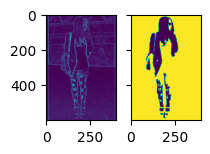

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import (
    felzenszwalb,
    slic,
    quickshift,
    watershed,
    mark_boundaries,
)
from skimage.util import img_as_float
from skimage import graph, color

# reference: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html
# reference: https://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html

img_path = "data/images/0001.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
fig, ax = plt.subplots(1, 2, figsize=(2, 2), sharex=True, sharey=True)
markers = np.zeros_like(img)
markers[img < 30] = 1
markers[img > 150] = 2
elevation_map = sobel(img)
segmentation = watershed(elevation_map, markers)
ax[0].imshow(elevation_map)
ax[1].imshow(segmentation)
plt.show()

Felzenszwalb number of segments: 49
SLIC number of segments: 13
Quickshift number of segments: 412
Watershed number of segments: 20


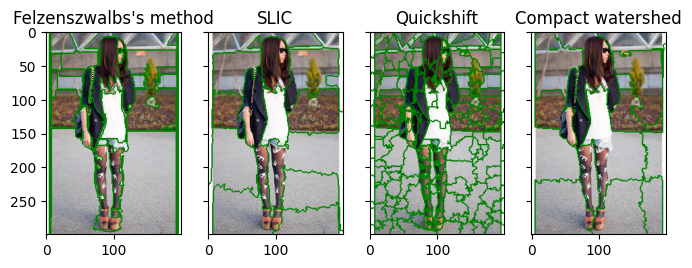

In [2]:
# Tring to tune some parameters
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img = img_as_float(image[::2, ::2])
segments_fz = felzenszwalb(img, scale=500, min_size=100)
segments_slic = slic(img, n_segments=20, compactness=10, sigma=1, start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=20, compactness=0.001)

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")
print(f"Watershed number of segments: {len(np.unique(segments_watershed))}")
fig, ax = plt.subplots(1, 4, figsize=(8, 5), sharex=True, sharey=True)

ax[0].imshow(mark_boundaries(img, segments_fz, color=(0, 0.5, 0)))
ax[0].set_title("Felzenszwalbs's method")
ax[1].imshow(mark_boundaries(img, segments_slic, color=(0, 0.5, 0)))
ax[1].set_title("SLIC")
ax[2].imshow(mark_boundaries(img, segments_quick, color=(0, 0.5, 0)))
ax[2].set_title("Quickshift")
ax[3].imshow(mark_boundaries(img, segments_watershed, color=(0, 0.5, 0)))
ax[3].set_title("Compact watershed")
plt.show()

In [3]:
# Now I will load my model remove the background and then segment the image with superpixels
import torch

best_model = torch.load("saved_models/DeepLabv3_2.pt")
best_model.eval()

DeepLabv3(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, ker

Felzenszwalb number of segments: 78
SLIC number of segments: 49


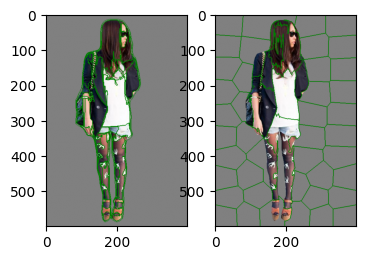

In [4]:
from utils import to_tensor_lab, remove_small_artifacts

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 2, figsize=(4, 4))

image_tensor = to_tensor_lab(image)
pred_mask = best_model(image_tensor.cuda())
pred_mask = pred_mask.argmax(dim=1).cpu().numpy()[0]
pred_mask = remove_small_artifacts(pred_mask, 300)
image[pred_mask == 0] = [128, 128, 128]
segments_fz = felzenszwalb(image, scale=150, min_size=100, channel_axis=2)
segments_slic = slic(image, n_segments=60, compactness=10)

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")

ax[0].imshow(mark_boundaries(image, segments_fz, color=(0, 0.5, 0)))
ax[1].imshow(mark_boundaries(image, segments_slic, color=(0, 0.5, 0)))
plt.show()

Number of segments ncuts: 58
Number of segments kmeans and ncuts: 32


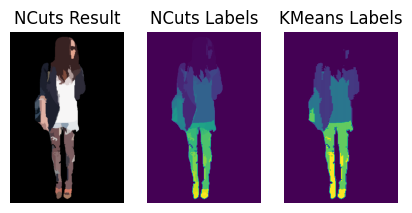

In [5]:
g = graph.rag_mean_color(image, segments_fz)
ncuts_labels_fz = graph.cut_threshold(segments_fz, g, 20)
ncuts_result_fz = color.label2rgb(ncuts_labels_fz, image, kind="avg")

print(f"Number of segments ncuts: {len(np.unique(ncuts_labels_fz))}")

fig, ax = plt.subplots(1, 3, figsize=(5, 5))
ax[0].imshow(ncuts_result_fz)
ax[0].set_title("NCuts Result")
ax[0].axis("off")
ax[1].imshow(ncuts_labels_fz)
ax[1].set_title("NCuts Labels")
ax[1].axis("off")


x = ncuts_labels_fz.reshape(-1, 4)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8).fit(x)
segmented_image = kmeans.cluster_centers_[kmeans.labels_]
segmented_image = segmented_image.reshape(ncuts_labels_fz.shape)

ax[2].imshow(segmented_image)
ax[2].set_title("KMeans Labels")
ax[2].axis("off")

print(f"Number of segments kmeans and ncuts: {len(np.unique(segmented_image))}")

plt.show()

In [6]:
# It seems that I can split the image into dissernable regions
# Maybe if I take each region as its own image and apply a classifier (similar to MNIST) to it I can get better results

Number of superpixels: 21


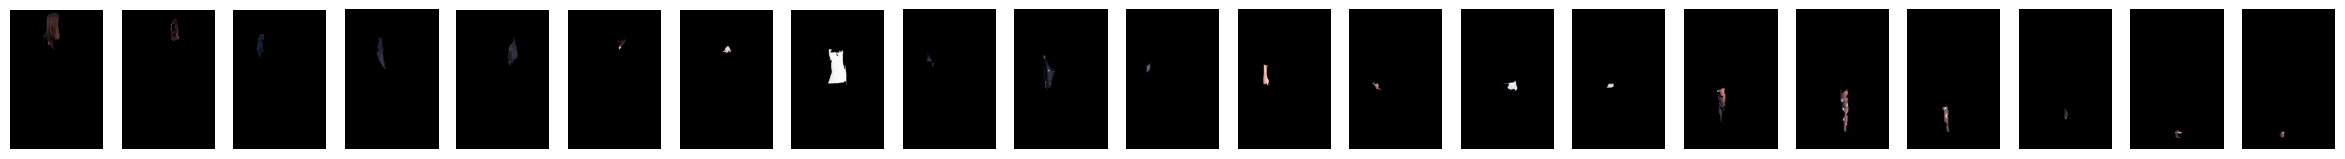

In [7]:
num_samples = 21
fig, ax = plt.subplots(1, num_samples, figsize=(30, 30))


def get_superpixel_images(image, segments) -> list:
    superpixel_images = []
    for segment in np.unique(segments):
        # I will ignore the segments that are too big or too small
        if segment <= 1 or np.sum(segments_fz == segment) < 400:
            continue
        superpixel_image = image.copy()
        superpixel_image[segments != segment] = [0, 0, 0]
        superpixel_images.append(superpixel_image)
    return superpixel_images


def get_superpixel_mask(image, segments) -> list:
    superpixel_mask = np.zeros(image.shape[:2])
    for segment in np.unique(segments):
        if segment <= 1:
            continue
        superpixel_mask[segments == segment] = segment
    return superpixel_mask


superpixel_images = get_superpixel_images(image, segments_fz)
print(f"Number of superpixels: {len(superpixel_images)}")
for i in range(num_samples):
    ax[i].imshow(superpixel_images[i])
    ax[i].axis("off")
plt.show()

Loading Images: 0001.jpg, ..., 0600.jpg
Loading Labels: 0001_clothes.png, ..., 0600_clothes.png


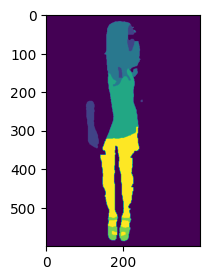

In [8]:
from ImageDataset import ImageSet
from collections import defaultdict

# Train a classifier on the superpixels
# Building the dataset for each superpixel find its matching label
MyClothesSet = ImageSet("data/images", "data/labels/clothes", label_type="multi")
_, img, gt = MyClothesSet[0]
gt_label = gt.squeeze(1).numpy()[0]
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(gt_label)
plt.show()

In [9]:
im = superpixel_images[0]
gt_freq = defaultdict(int)

for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        if np.sum(im[i, j]) != 0:
            gt_freq[gt_label[i, j]] += 1

print(gt_freq)
# key corresponding to the most frequent value
max_key = max(gt_freq, key=gt_freq.get)

defaultdict(<class 'int'>, {2: 6389, 0: 302, 3: 1})


In [10]:
import matplotlib.image

# By doing this I hope to create a large dataset of fashion item images with their corresponding labels

# item_number = 0
# for idx, img_tensor, gt in MyClothesSet:
#     image = MyClothesSet.images[idx]
#     pred_mask = best_model(img_tensor.unsqueeze(0).cuda())
#     pred_mask = pred_mask.argmax(dim=1).cpu().numpy()[0]
#     pred_mask = remove_small_artifacts(pred_mask, 300)
#     image[pred_mask == 0] = [0, 0, 0]
#     segments_fz = felzenszwalb(image, scale=150, min_size=100, channel_axis=2)

#     superpixel_images = get_superpixel_images(image, segments_fz)
#     # cap the number of superpixels to 10
#     superpixel_images = superpixel_images[:10]

#     gt_label = gt.squeeze(1).numpy()[0]

#     for superpixel_image in superpixel_images:
#         gt_freq = defaultdict(int)
#         for i in range(superpixel_image.shape[0]):
#             for j in range(superpixel_image.shape[1]):
#                 if np.sum(superpixel_image[i, j]) != 0:
#                     gt_freq[gt_label[i, j]] += 1
#         try:
#             max_key = max(gt_freq, key=gt_freq.get)
#             matplotlib.image.imsave(
#                 f"data/fashion_items/{max_key}/{(item_number+1):04d}.png",
#                 superpixel_image,
#             )
#         except:
#             continue
#         item_number += 1
#         if item_number % 100 == 0:
#             print(f"Saved {item_number} as a {max_key} fashion item")

In [11]:
# The challenge here is that to preerve information there will be many super pixels that are not useful and many that are not properly grouped ie. two super pixels that are part of the same class (ex. two shoes)

# Now I can write a classifier color texture and position can give useful information to classify the super pixels
# After they are classified I can shade them in as my prediction

In [12]:
# I would like to try one last startegy
# Make a predicition on the image with the CNN then for each superpixel classify it as the mean pixel value of the CNN prediction at that superpixel

In [13]:
import torch

best_model = torch.load("saved_models/DeepLabv3_7.pt")
best_model.eval()

inverse_color_map = {
    0: np.array((0, 0, 0)),  # background
    1: np.array((128, 0, 0)),  # skin
    2: np.array((0, 128, 0)),  # hair
    3: np.array((128, 128, 0)),  # tshirt
    4: np.array((0, 0, 128)),  # shoes
    5: np.array((128, 0, 128)),  # pants
    6: np.array((0, 128, 128)),  # dress
}

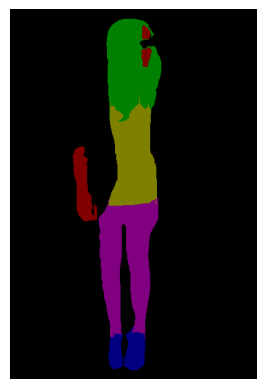

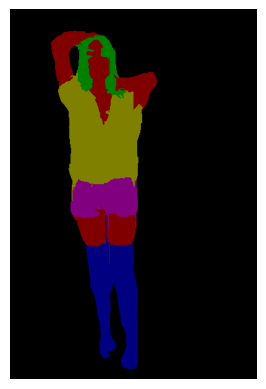

In [14]:
for idx, img_tensor, gt in MyClothesSet:
    if idx >= 2:
        break

    image = MyClothesSet.images[idx]
    pred_mask = best_model(img_tensor.unsqueeze(0).cuda())
    pred_mask = pred_mask.argmax(dim=1).cpu().numpy()[0]
    pred_mask = remove_small_artifacts(pred_mask, 100)
    image[pred_mask == 0] = [0, 0, 0]
    segments_fz = felzenszwalb(image, scale=150, min_size=100, channel_axis=2)
    superpixel_mask = get_superpixel_mask(image, segments_fz)
    prediction = np.zeros((600, 400, 3), dtype=np.uint8)

    for superpixel in np.unique(superpixel_mask):
        freq = defaultdict(int)
        for i in range(prediction.shape[0]):
            for j in range(prediction.shape[1]):
                if superpixel_mask[i, j] == superpixel:
                    freq[pred_mask[i, j]] += 1
        try:
            max_key = max(freq, key=freq.get)
            prediction[superpixel_mask == superpixel] = inverse_color_map[max_key]
        except:
            continue

    plt.imshow(prediction)
    plt.axis("off")
    plt.show()

    # This takes a while to compute (maybe can be optimized)

In [15]:
# I can try to use ncuts to segment the image and then classify each segment with the CNN

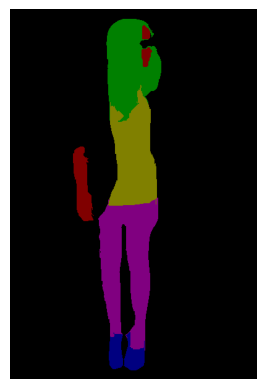

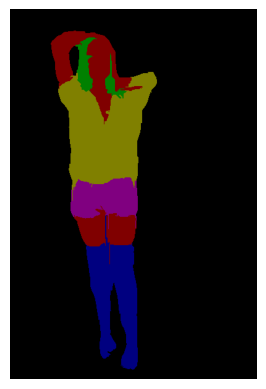

In [16]:
for idx, img_tensor, gt in MyClothesSet:
    if idx >= 2:
        break

    image = MyClothesSet.images[idx]
    pred_mask = best_model(img_tensor.unsqueeze(0).cuda())
    pred_mask = pred_mask.argmax(dim=1).cpu().numpy()[0]
    pred_mask = remove_small_artifacts(pred_mask, 100)
    image[pred_mask == 0] = [0, 0, 0]
    segments_fz = felzenszwalb(image, scale=150, min_size=100, channel_axis=2)
    g = graph.rag_mean_color(image, segments_fz)
    ncuts_labels_fz = graph.cut_threshold(segments_fz, g, 20)
    prediction = np.zeros((600, 400, 3), dtype=np.uint8)

    for label in np.unique(ncuts_labels_fz):
        if label < 1:
            continue

        indicies = []
        freq = defaultdict(int)
        for i in range(prediction.shape[0]):
            for j in range(prediction.shape[1]):
                if ncuts_labels_fz[i, j] == label:
                    indicies.append((i, j))
                    freq[pred_mask[i, j]] += 1

        try:
            max_key = max(freq, key=freq.get)
            for i, j in indicies:
                prediction[i, j] = inverse_color_map[max_key]
        except:
            continue

    plt.imshow(prediction)
    plt.axis("off")
    plt.show()

    # This losses some detail